In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
BASE_PATH = Path("..")
sys.path.append(str(BASE_PATH.resolve()))

In [5]:
from src.mobilenetv1.mobilenetv1 import MobileNetV1

In [6]:
tf.__version__

'2.5.0'

## CIFAR-10 Dataset

In [7]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [9]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# train_images = resize(train_images, (len(train_images),224,224,3))
# test_images = resize(test_images, (len(test_images),224,224,3))

train_images = train_images / 255.
test_images = test_images / 255.

train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=len(CLASS_NAMES))
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=len(CLASS_NAMES))

In [11]:
train_images.shape

(50000, 32, 32, 3)

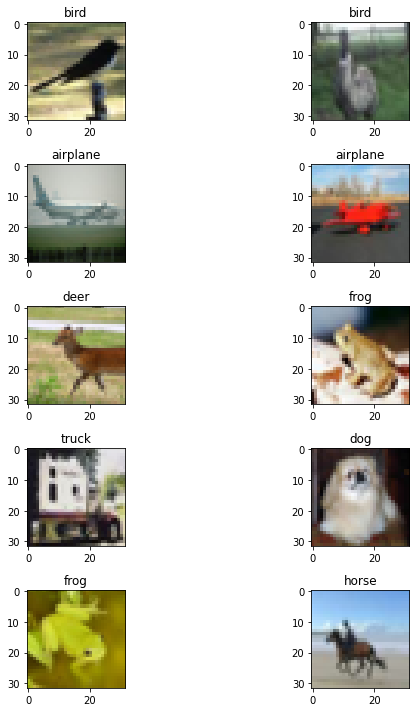

In [12]:
SAMPLE_SIZE = 10
samples = np.random.randint(0, len(train_images), size = SAMPLE_SIZE)

fig, axarr = plt.subplots(5, SAMPLE_SIZE//5, figsize = (10,10))
axs = axarr.ravel()

for idx, sample in enumerate(samples):
    axs[idx].imshow(train_images[sample,:,:,:])
    axs[idx].set_title(CLASS_NAMES[train_labels[sample,0]])
    
plt.tight_layout()

## Train MobilenetV1

In [13]:
ARTEFACT_DIR = Path('./artefacts/mobilenetv1')
if not ARTEFACT_DIR.exists():
    ARTEFACT_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
mobilenetv1 = MobileNetV1(train_images.shape[1:], len(CLASS_NAMES), alpha=1.0)
model = mobilenetv1()

2021-10-25 04:13:41.539985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt,
              loss=['categorical_crossentropy'],
              metrics=['accuracy'])

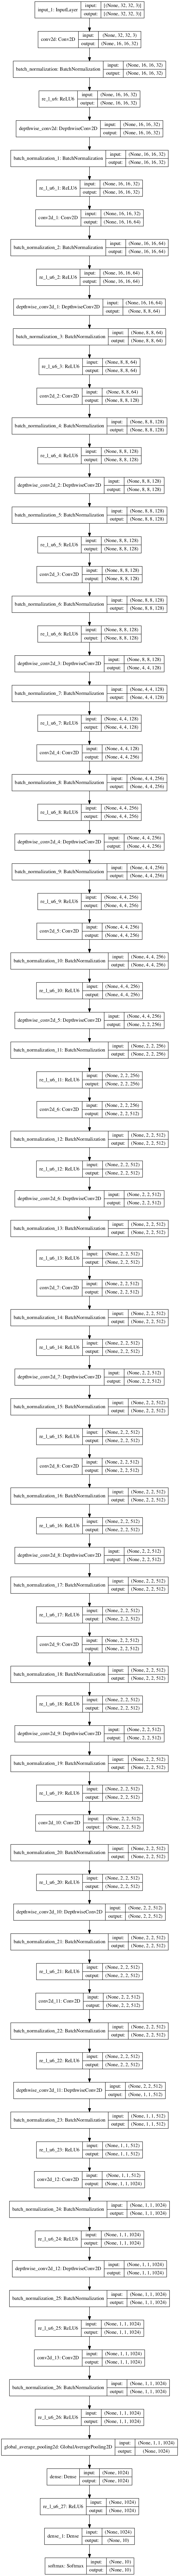

In [16]:
tf.keras.utils.plot_model(model, ARTEFACT_DIR / "mobilenetv1_info.png", show_shapes=True)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
re_l_u6 (ReLU6)              (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
re_l_u6_1 (ReLU6)            (None, 16, 16, 32)        0     

In [18]:
model.save(ARTEFACT_DIR / 'mobilenetv1.h5')

In [19]:
model.fit(x = train_images, y = train_labels_onehot, validation_split=0.20, verbose=1,epochs = 10)

2021-10-25 04:13:45.149789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1250/1250 [==============================] - 228s 180ms/step - loss: 2.1038 - accuracy: 0.2165 - val_loss: 1.9143 - val_accuracy: 0.2850
Epoch 2/10
1250/1250 [==============================] - 215s 172ms/step - loss: 1.7689 - accuracy: 0.3416 - val_loss: 1.6768 - val_accuracy: 0.3817
Epoch 3/10
1250/1250 [==============================] - 213s 170ms/step - loss: 1.5974 - accuracy: 0.4147 - val_loss: 1.5254 - val_accuracy: 0.4365
Epoch 4/10
1250/1250 [==============================] - 220s 176ms/step - loss: 1.4780 - accuracy: 0.4622 - val_loss: 1.5183 - val_accuracy: 0.4380
Epoch 5/10
1250/1250 [==============================] - 216s 173ms/step - loss: 1.3883 - accuracy: 0.4997 - val_loss: 1.3817 - val_accuracy: 0.4919
Epoch 6/10
1250/1250 [==============================] - 232s 185ms/step - loss: 1.3064 - accuracy: 0.5307 - val_loss: 1.3496 - val_accuracy: 0.5147
Epoch 7/10
1250/1250 [==============================] - 271s 217ms/step - loss: 1.2365 - accuracy: 0.5587 - val_

## Evaluate MobilenetV1

In [20]:
test_loss, test_acc = model.evaluate(test_images,  test_labels_onehot, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 6s - loss: 1.2469 - accuracy: 0.5703

Test accuracy: 0.5702999830245972
